In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import csv

In [4]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
print(ratings.shape[0])

100836


In [42]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
print(movies.shape[0])

9742


In [9]:
print(ratings['userId'].nunique())

610


In [10]:
print(round((int(ratings.shape[0]))/int(ratings['userId'].nunique()),2))

165.3


In [11]:
print(round((int(ratings.shape[0]))/int(movies.shape[0]),2))

10.35


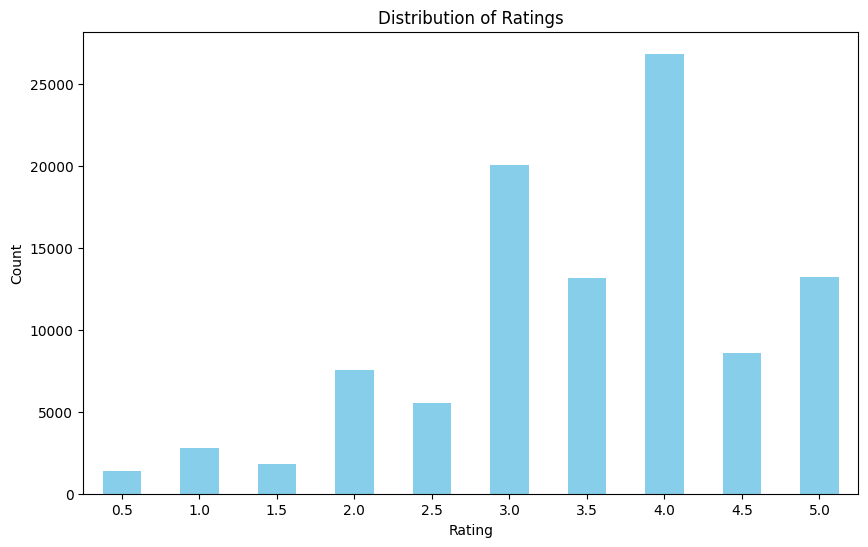

In [12]:
rating_counts = ratings['rating'].value_counts().sort_index()

# Plotting the distribution graph
plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [13]:
movie_titles = dict(zip(movies['movieId'],movies['title']))

In [23]:
# Calculate average rating and count of ratings for each movie
movie_ratings = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])

# Rename columns for clarity
movie_ratings.columns = ['average_rating', 'rating_count']

# Construct the final DataFrame with movie ID, average rating, and rating count
movie_stats = pd.DataFrame({
    'average_rating': movie_ratings['average_rating'],
    'rating_count': movie_ratings['rating_count']
})

# Display the first few rows of the new DataFrame
print(movie_stats.head())

         average_rating  rating_count
movieId                              
1              3.920930           215
2              3.431818           110
3              3.259615            52
4              2.357143             7
5              3.071429            49


In [25]:
C = movie_stats['rating_count'].mean()
m = movie_stats['average_rating'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [26]:
movie_stats.head()

,movieId,average_rating,rating_count,bayesian_avg
0,1,3.920930,215,3.890632
1,2,3.431818,110,3.417227
2,3,3.259615,52,3.260086
3,4,2.357143,7,2.897612
4,5,3.071429,49,3.104793


In [34]:
from scipy.sparse import csr_matrix

def create_sparse(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper,movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper,movie_inv_mapper = create_sparse(ratings)

In [37]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])
sparsity_p = round(sparsity*100,2)
print(f"Matrix sparsity: {sparsity_p}%")

Matrix sparsity: 1.7%


In [38]:
n_ratings_per_user = X.getnnz(axis=1)

In [45]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [52]:
#dokończyć (wywołanie metody)
def findSimilarMovies(Movie_id, num_of_movies):
    array = find_similar_movies(Movie_id, X, movie_mapper, movie_inv_mapper, num_of_movies)

    suggestionArray = []

    for i in array:
        title = movie_titles.get(i)  # Get the title from the dictionary
        suggestionArray.append(title)

    print(suggestionArray)

findSimilarMovies(1, 10)

['Toy Story 2 (1999)', 'Jurassic Park (1993)', 'Independence Day (a.k.a. ID4) (1996)', 'Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Lion King, The (1994)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Mission: Impossible (1996)', 'Groundhog Day (1993)']
